In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [12]:
BASE_DIR = r'C:\Users\mailg\Desktop\Projects\Gender and Age Detection\Datasets\utkface_aligned_cropped\UTKFace'

In [13]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  C:\Users\mailg\Desktop\Projects\Gender and Age...  100       0
1  C:\Users\mailg\Desktop\Projects\Gender and Age...  100       0
2  C:\Users\mailg\Desktop\Projects\Gender and Age...  100       1
3  C:\Users\mailg\Desktop\Projects\Gender and Age...  100       1
4  C:\Users\mailg\Desktop\Projects\Gender and Age...  100       1

In [15]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

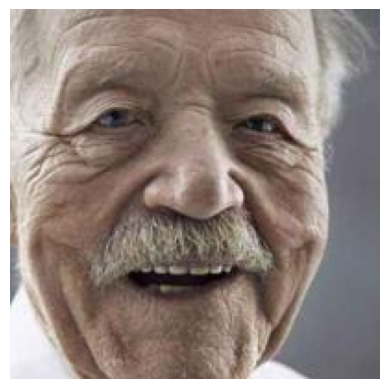

In [16]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

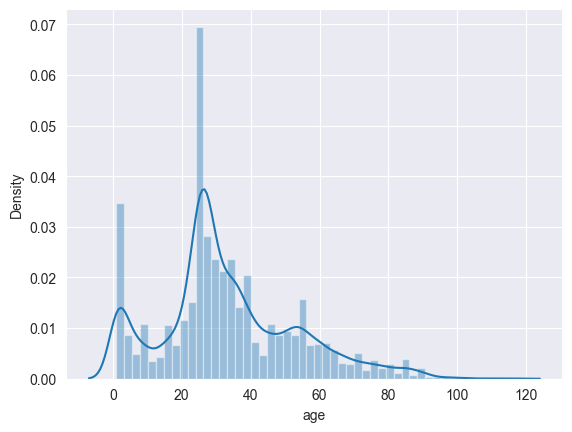

In [17]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

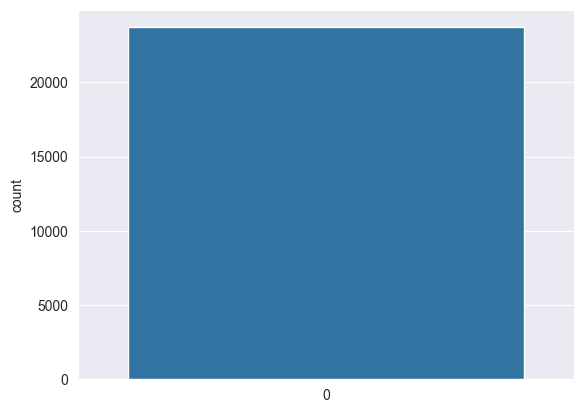

In [18]:
sns.countplot(df['gender'])

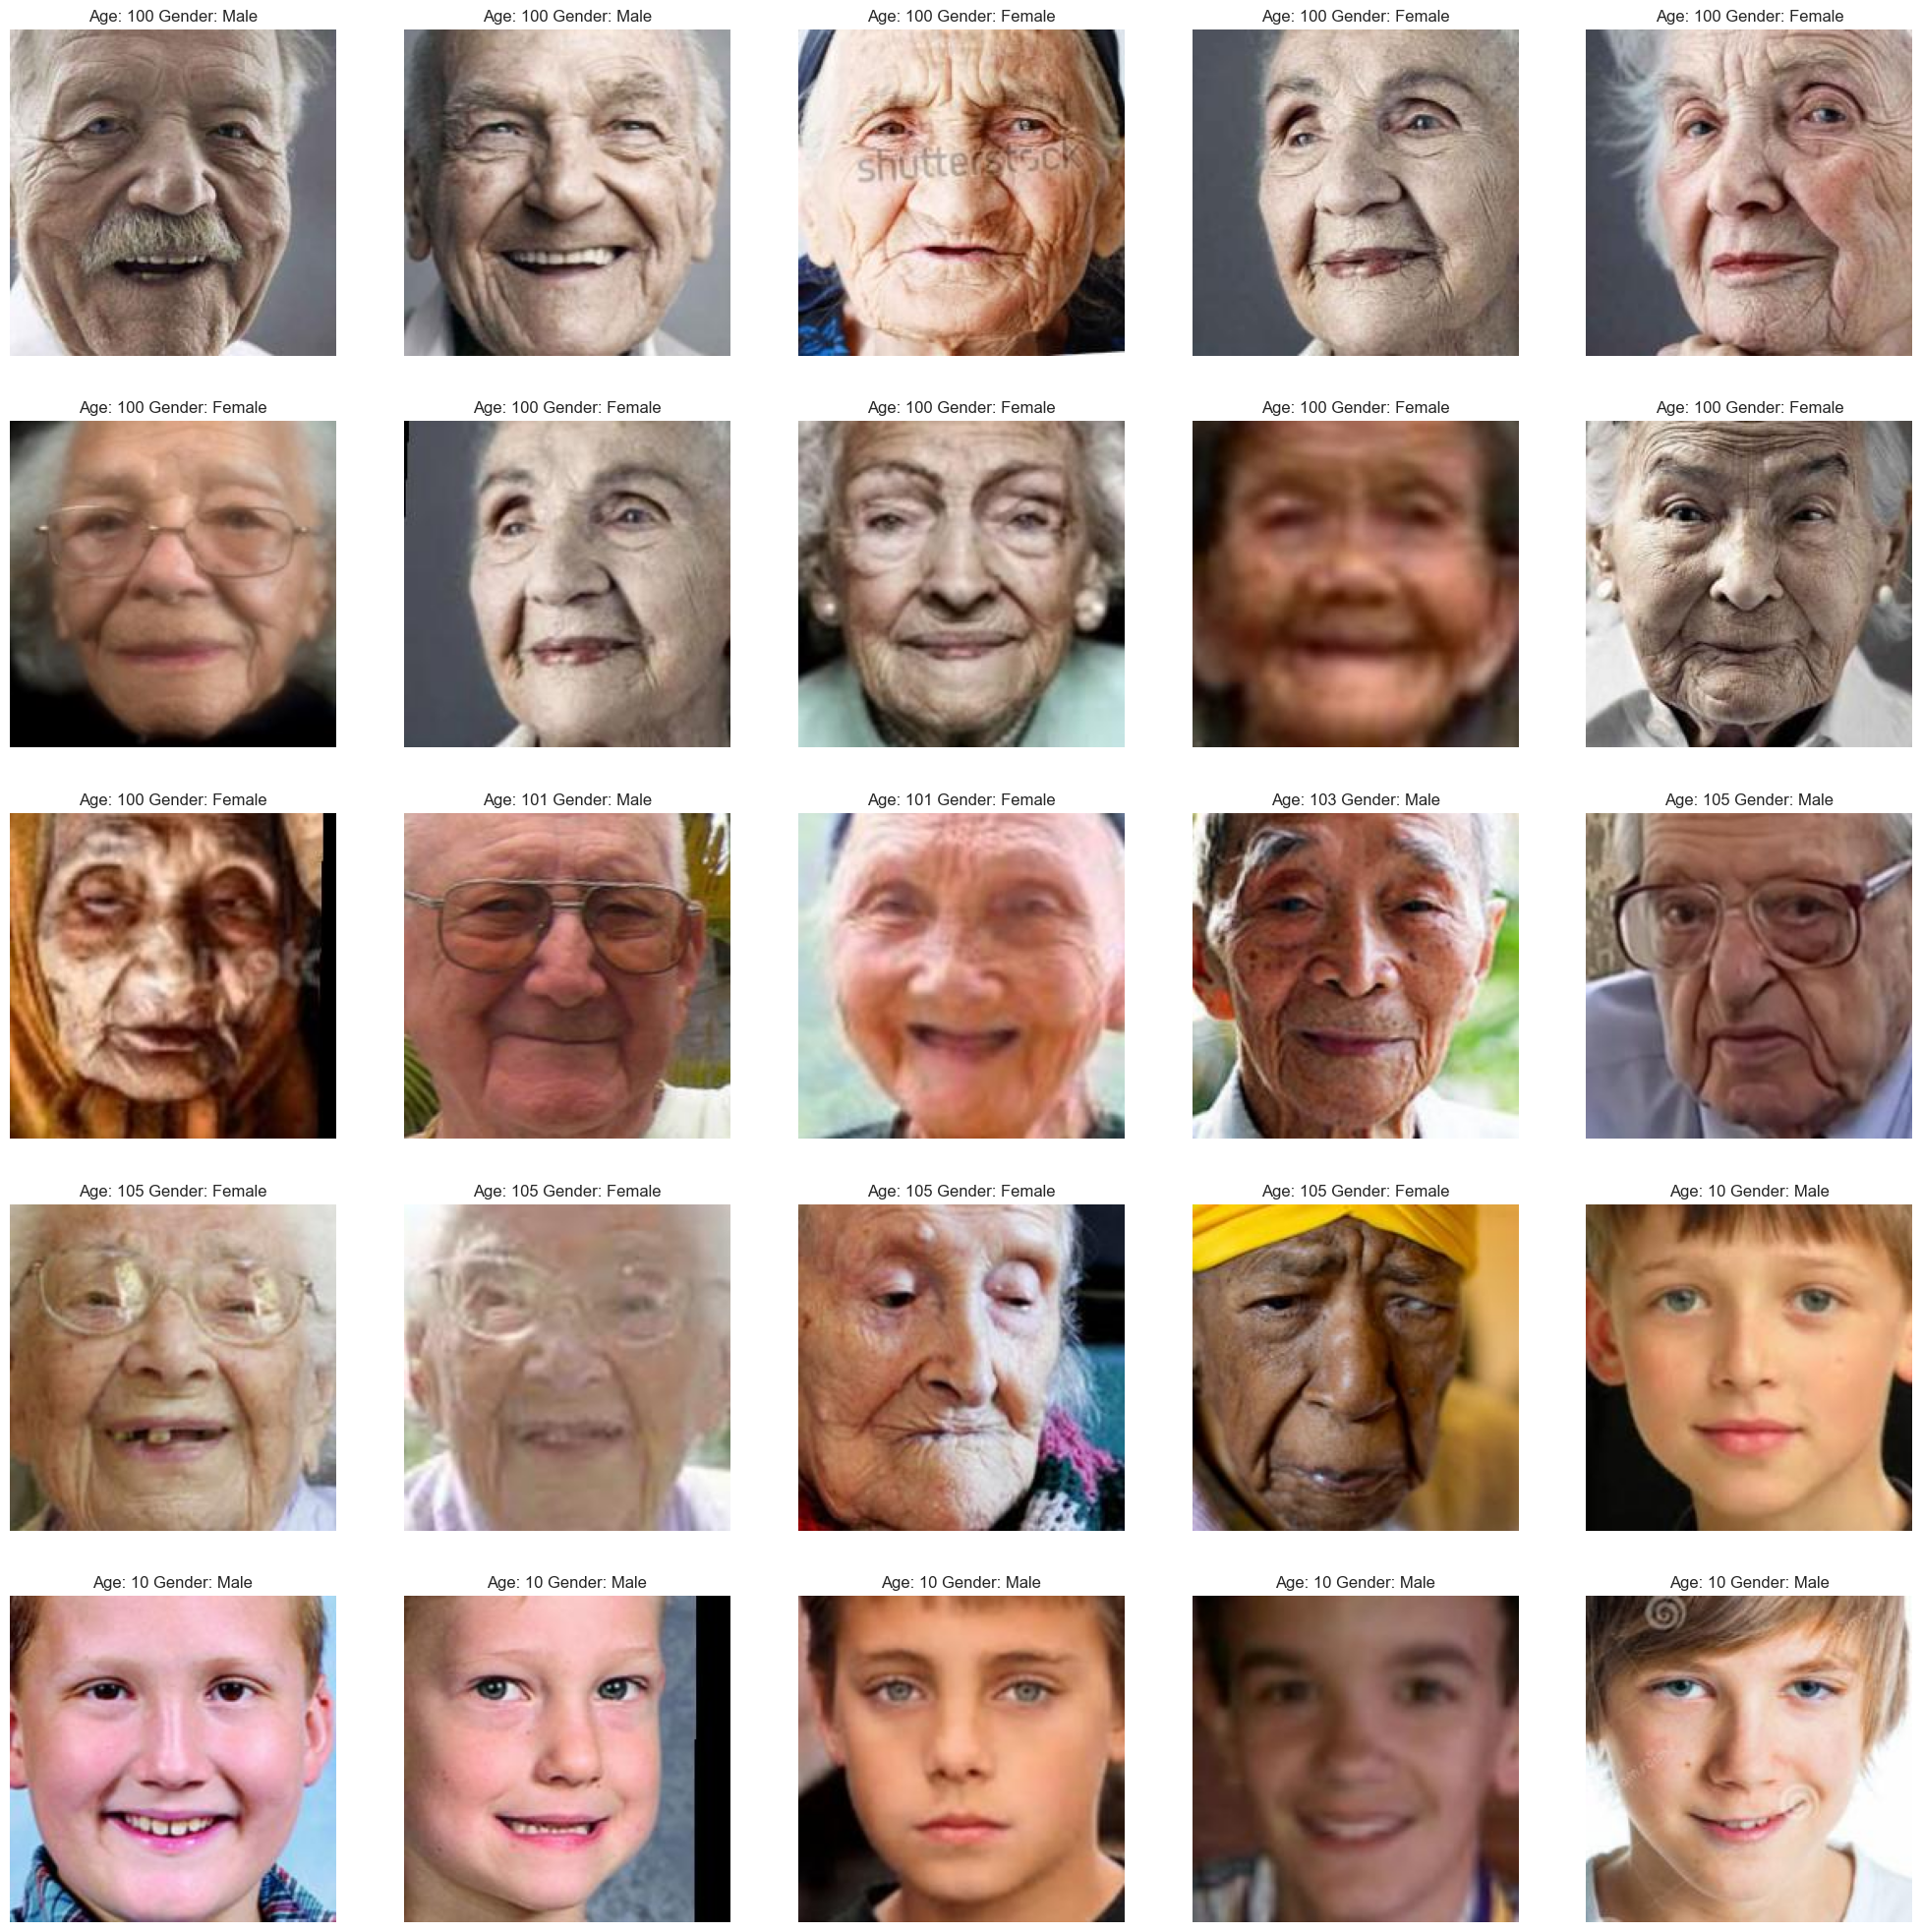

In [19]:
# to display grid of images
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [20]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [21]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [22]:
X.shape

(23708, 128, 128, 1)

In [23]:
# normalize the images
X = X/255.0

In [24]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [25]:
input_shape = (128, 128, 1)

In [26]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [27]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 573s 955ms/step - loss: 11.1516 - gender_out_loss: 0.6915 - age_out_loss: 10.4601 - gender_out_accuracy: 0.5242 - age_out_accuracy: 0.0588 - val_loss: 33.5084 - val_gender_out_loss: 0.6566 - val_age_out_loss: 32.8517 - val_gender_out_accuracy: 0.6181 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 610s 1s/step - loss: 8.2457 - gender_out_loss: 0.4970 - age_out_loss: 7.7487 - gender_out_accuracy: 0.7608 - age_out_accuracy: 0.0460 - val_loss: 32.6087 - val_gender_out_loss: 0.5070 - val_age_out_loss: 32.1017 - val_gender_out_accuracy: 0.7493 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 699s 1s/step - loss: 7.3265 - gender_out_loss: 0.3901 - age_out_loss: 6.9364 - gender_out_accuracy: 0.8229 - age_out_accuracy: 0.0378 - val_loss: 26.6375 - val_gender_out_loss: 0.5009 - val_age_out_loss: 26.1366 - val_gender_out_accuracy: 0.7710 - val_age_out_accuracy: 0

<Figure size 640x480 with 0 Axes>

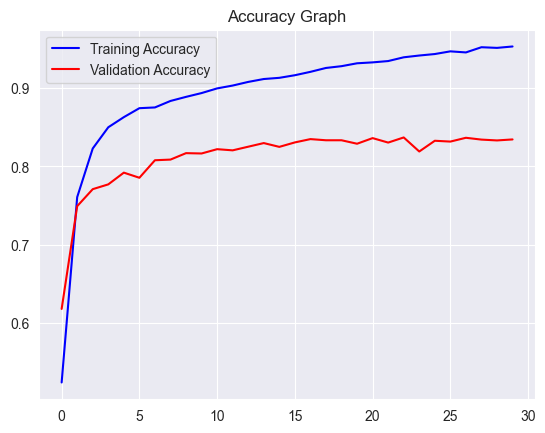

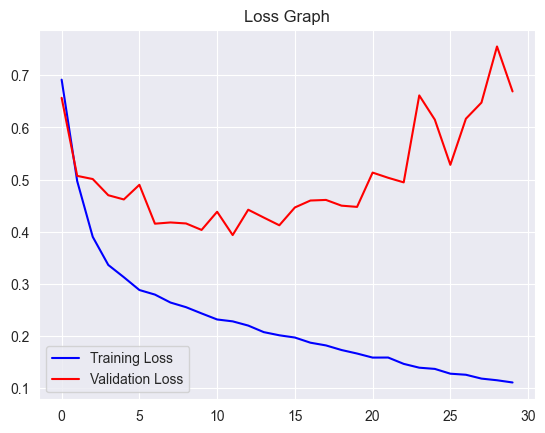

<Figure size 640x480 with 0 Axes>

In [29]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

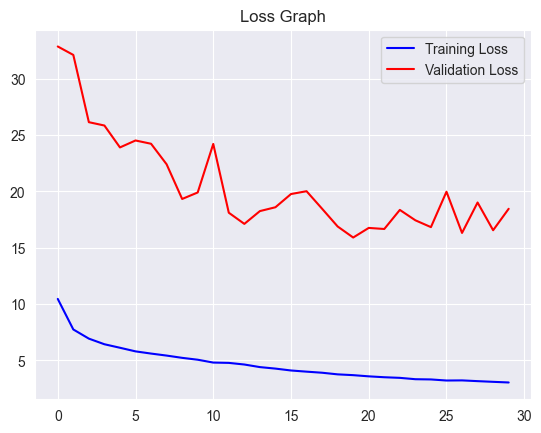

In [30]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 1s 899ms/step
Predicted Gender: Male Predicted Age: 14


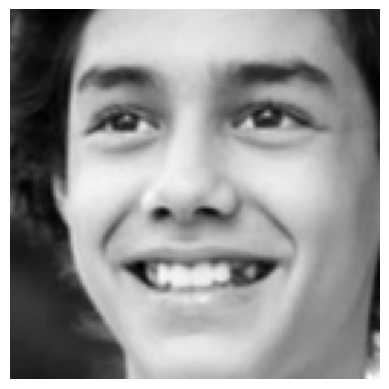

In [31]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 331ms/step
Predicted Gender: Male Predicted Age: 21


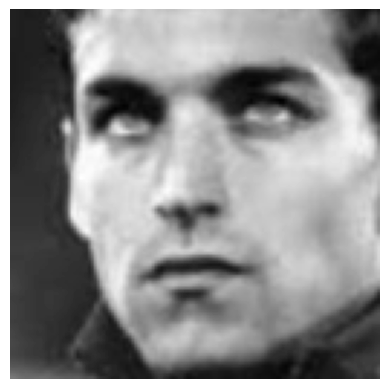

In [32]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 1s 1s/step
Predicted Gender: Female Predicted Age: 27


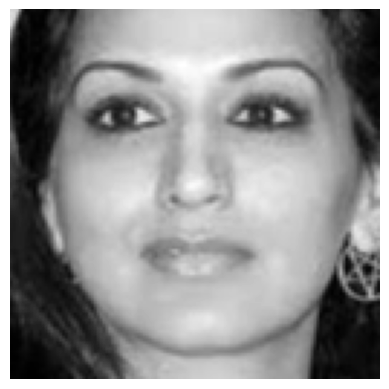

In [33]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');